<a href="https://colab.research.google.com/github/prakash-bisht/Reinforcement-Learning/blob/main/Reinforcement_Learning_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

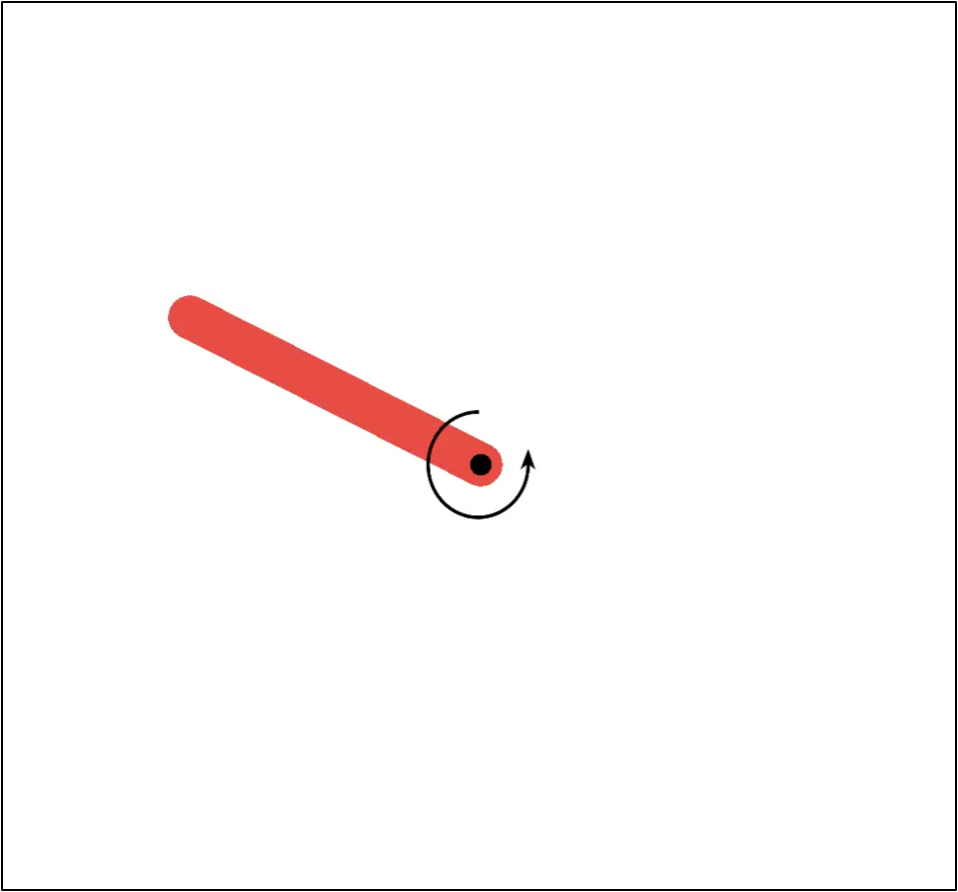

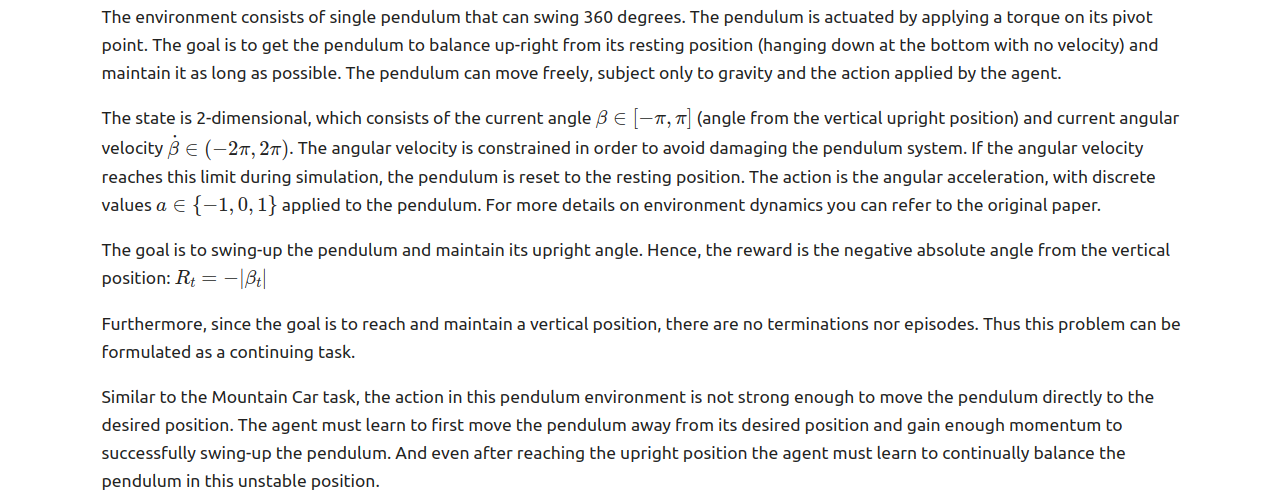

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
from tqdm import tqdm

from rl_glue import RLGlue
from pendulum_env import PendulumEnvironment
from agent import BaseAgent
import plot_script
import tiles3 as tc

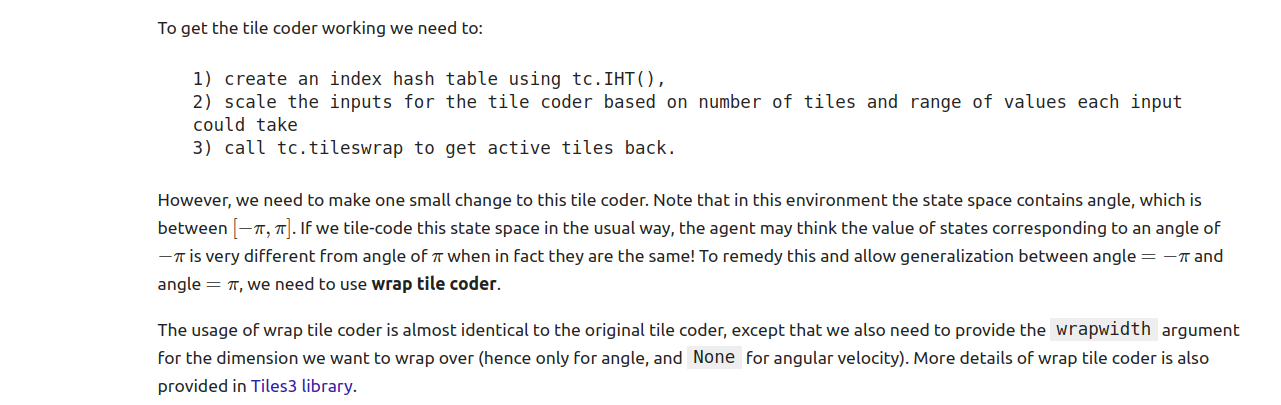

In [ ]:
class PendulumTileCoder:
    def __init__(self, iht_size=4096, num_tilings=32, num_tiles=8):
        """
        Initializes the MountainCar Tile Coder
        Initializers:
        iht_size -- int, the size of the index hash table, typically a power of 2
        num_tilings -- int, the number of tilings
        num_tiles -- int, the number of tiles. Here both the width and height of the tiles are the same

        Class Variables:
        self.iht -- tc.IHT, the index hash table that the tile coder will use
        self.num_tilings -- int, the number of tilings the tile coder will use
        self.num_tiles -- int, the number of tiles the tile coder will use
        """

        self.num_tilings = num_tilings
        self.num_tiles = num_tiles
        self.iht = tc.IHT(iht_size)

    def get_tiles(self, angle, ang_vel):
        """
        Takes in an angle and angular velocity from the pendulum environment
        and returns a numpy array of active tiles.

        Arguments:
        angle -- float, the angle of the pendulum between -np.pi and np.pi
        ang_vel -- float, the angular velocity of the agent between -2*np.pi and 2*np.pi

        returns:
        tiles -- np.array, active tiles
        """
        ANGEL_MIN = -np.pi
        ANGEL_MAX = np.pi

        ANG_VEL_MIN = -2 * np.pi
        ANG_VEL_MAX = 2 * np.pi

        angle_scale = self.num_tiles/(ANGEL_MAX - ANGEL_MIN)
        ang_vel_scale = self.num_tiles/(ANG_VEL_MAX - ANG_VEL_MIN)

        tiles = tc.tileswrap(self.iht, self.num_tilings, [angle * angle_scale, ang_vel * ang_vel_scale], wrapwidths=[self.num_tiles, False])

        return np.array(tiles)



We will implement the same average reward Actor-Critic algorithm presented in the videos.

This agent has two components: an Actor and a Critic. The Actor learns a parameterized policy while the Critic learns a state-value function. The environment has discrete actions; your Actor implementation will use a softmax policy with exponentiated action-preferences. The Actor learns with the sample-based estimate for the gradient of the average reward objective. The Critic learns using the average reward version of the semi-gradient TD(0) algorithm.

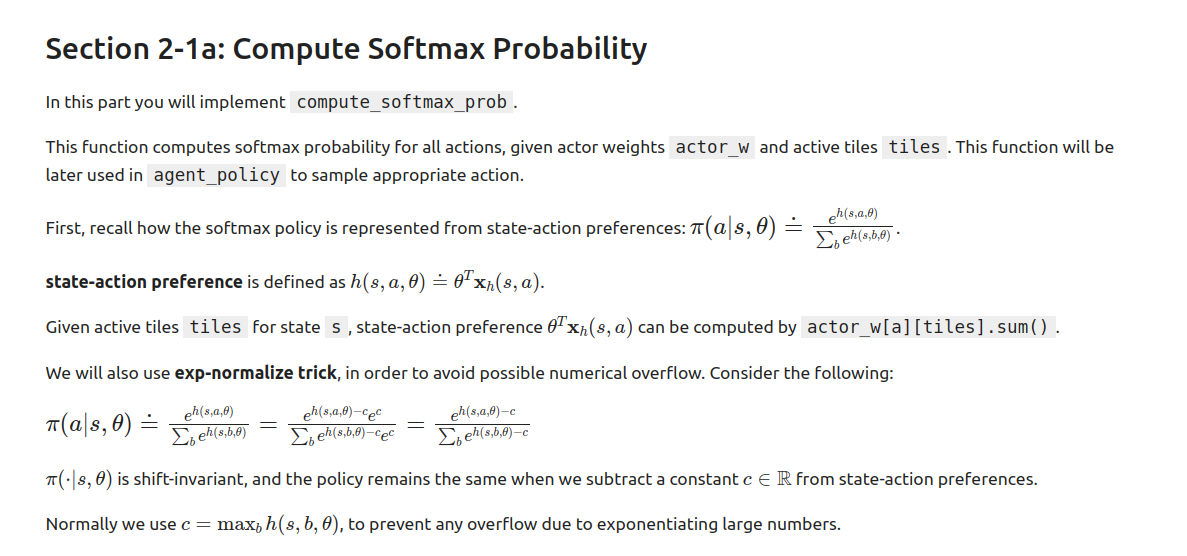

In [ ]:
def compute_softmax_prob(actor_w, tiles):
    """
    Computes softmax probability for all actions

    Args:
    actor_w - np.array, an array of actor weights
    tiles - np.array, an array of active tiles

    Returns:
    softmax_prob - np.array, an array of size equal to num. actions, and sums to 1.
    """

    state_action_preferences = []
    state_action_preferences = actor_w[:,tiles].sum(axis=1)

    c = np.max(state_action_preferences)

    numerator = np.exp(state_action_preferences -c)
    denominator = np.sum(numerator)

    softmax_prob = numerator/ denominator

    return softmax_prob

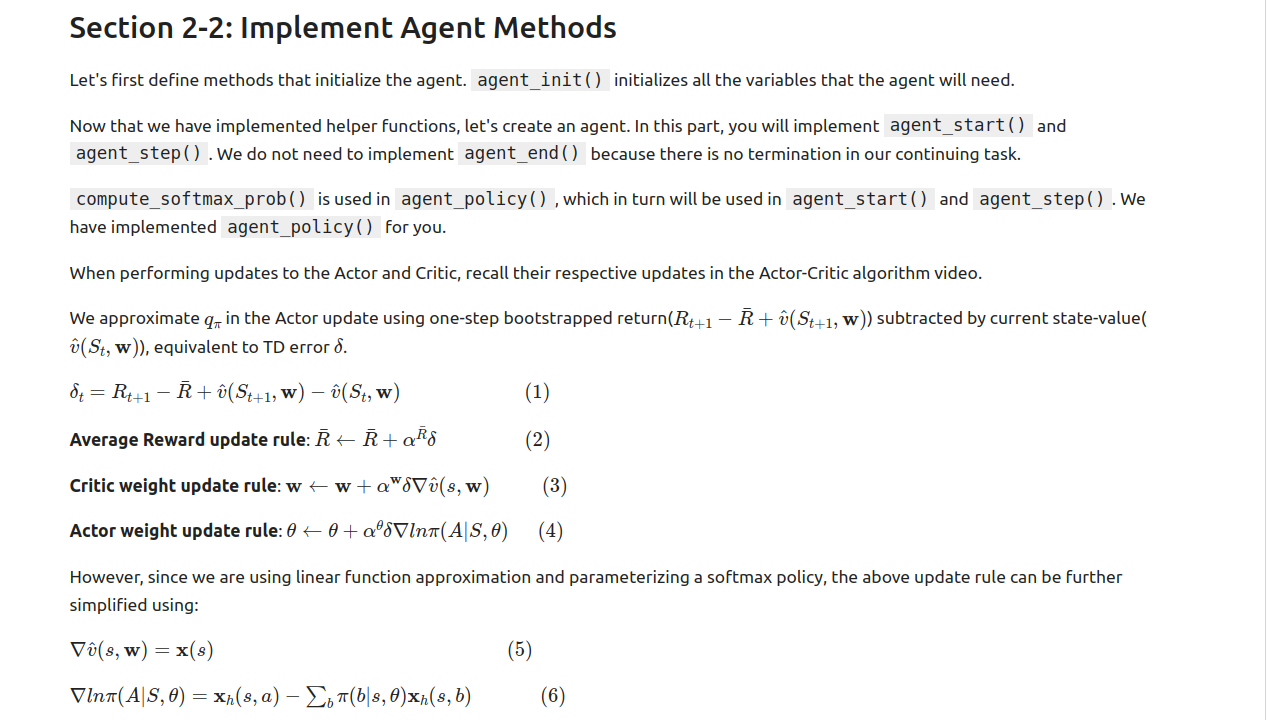

In [ ]:
class ActorCriticSoftmaxAgent(BaseAgent):
    def __init__(self):
        self.rand_generator = None

        self.actor_step_size = None
        self.critic_step_size = None
        self.avg_reward_step_size = None

        self.tc = None

        self.avg_reward = None
        self.critic_w = None
        self.actor_w = None

        self.actions = None

        self.softmax_prob = None
        self.prev_tiles = None
        self.last_action = None

    def agent_init(self, agent_info={}):
        """Setup for the agent called when the experiment first starts.

        Set parameters needed to setup the semi-gradient TD(0) state aggregation agent.

        Assume agent_info dict contains:
        {
            "iht_size": int
            "num_tilings": int,
            "num_tiles": int,
            "actor_step_size": float,
            "critic_step_size": float,
            "avg_reward_step_size": float,
            "num_actions": int,
            "seed": int
        }
        """

        self.rand_generator = np.random.RandomState(agent_info.get("seed"))

        iht_size = agent_info.get("iht_size")
        num_tilings = agent_info.get("num_tilings")
        num_tiles = agent_info.get("num_tiles")

        self.tc = PendulumTileCoder(iht_size=iht_size, num_tilings=num_tilings, num_tiles=num_tiles)

        self.actor_step_size = agent_info.get("actor_step_size")/num_tilings
        self.critic_step_size = agent_info.get("critic_step_size")/num_tilings
        self.avg_reward_step_size = agent_info.get("avg_reward_step_size")

        self.actions = list(range(agent_info.get("num_actions")))

        self.avg_reward = 0.0
        self.actor_w = np.zeros((len(self.actions), iht_size))
        self.critic_w = np.zeros(iht_size)

        self.softmax_prob = None
        self.prev_tiles = None
        self.last_action = None

    def agent_policy(self, active_tiles):
        """ policy of the agent
        Args:
            active_tiles (Numpy array): active tiles returned by tile coder

        Returns:
            The action selected according to the policy
        """
        softmax_prob = compute_softmax_prob(self.actor_w,active_tiles)
        chosen_action = self.rand_generator.choice(self.actions,p=softmax_prob)
        self.softmax_prob = softmax_prob
        return chosen_action

    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state from the environment's env_start function.
        Returns:
            The first action the agent takes.
        """

        angle, ang_vel = state

        active_tiles = self.tc.get_tiles(angle,ang_vel)
        current_action = self.agent_policy(active_tiles)

        self.last_action = current_action
        self.prev_tiles = np.copy(active_tiles)

        return self.last_action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state from the environment's step based on
                                where the agent ended up after the
                                last step.
        Returns:
            The action the agent is taking.
        """

        angle, ang_vel = state

        active_tiles = self.tc.get_tiles(angle,ang_vel)
        delta = reward - self.avg_reward + self.critic_w[active_tiles].sum() - self.critic_w[self.prev_tiles].sum()
        self.avg_reward += self.avg_reward_step_size * delta
        self.critic_w += self.critic_step_size * delta

        for a in self.actions:
          if a == self.last_action:
            self.actor_w[a][self.prev_tiles] += self.actor_step_size * delta * (1 - self.softmax_prob[a])
          else:
            self.actor_w[a][self.prev_tiles] += self.actor_step_size * delta * (0 - self.softmax_prob[a])

        current_action = self.agent_policy(active_tiles)

        self.prev_tiles = np.copy(active_tiles)
        self.last_action = current_action

        return self.last_action

    def agent_message(self, message):
        if message == 'get avg reward':
            return self.avg_reward


In [ ]:
def run_experiment(environment, agent, environment_parameters, agent_parameters, experiment_parameters):

    rl_glue = RLGlue(environment, agent)

    # sweep agent parameters
    for num_tilings in agent_parameters['num_tilings']:
        for num_tiles in agent_parameters["num_tiles"]:
            for actor_ss in agent_parameters["actor_step_size"]:
                for critic_ss in agent_parameters["critic_step_size"]:
                    for avg_reward_ss in agent_parameters["avg_reward_step_size"]:

                        env_info = {}
                        agent_info = {"num_tilings": num_tilings,
                                      "num_tiles": num_tiles,
                                      "actor_step_size": actor_ss,
                                      "critic_step_size": critic_ss,
                                      "avg_reward_step_size": avg_reward_ss,
                                      "num_actions": agent_parameters["num_actions"],
                                      "iht_size": agent_parameters["iht_size"]}

                        # results to save
                        return_per_step = np.zeros((experiment_parameters["num_runs"], experiment_parameters["max_steps"]))
                        exp_avg_reward_per_step = np.zeros((experiment_parameters["num_runs"], experiment_parameters["max_steps"]))

                        # using tqdm we visualize progress bars
                        for run in tqdm(range(1, experiment_parameters["num_runs"]+1)):
                            env_info["seed"] = run
                            agent_info["seed"] = run

                            rl_glue.rl_init(agent_info, env_info)
                            rl_glue.rl_start()

                            num_steps = 0
                            total_return = 0.
                            return_arr = []

                            # exponential average reward without initial bias
                            exp_avg_reward = 0.0
                            exp_avg_reward_ss = 0.01
                            exp_avg_reward_normalizer = 0

                            while num_steps < experiment_parameters['max_steps']:
                                num_steps += 1

                                rl_step_result = rl_glue.rl_step()

                                reward = rl_step_result[0]
                                total_return += reward
                                return_arr.append(reward)
                                avg_reward = rl_glue.rl_agent_message("get avg reward")

                                exp_avg_reward_normalizer = exp_avg_reward_normalizer + exp_avg_reward_ss * (1 - exp_avg_reward_normalizer)
                                ss = exp_avg_reward_ss / exp_avg_reward_normalizer
                                exp_avg_reward += ss * (reward - exp_avg_reward)

                                return_per_step[run-1][num_steps-1] = total_return
                                exp_avg_reward_per_step[run-1][num_steps-1] = exp_avg_reward

                        if not os.path.exists('results'):
                            os.makedirs('results')

                        save_name = "ActorCriticSoftmax_tilings_{}_tiledim_{}_actor_ss_{}_critic_ss_{}_avg_reward_ss_{}".format(num_tilings, num_tiles, actor_ss, critic_ss, avg_reward_ss)
                        total_return_filename = "results/{}_total_return.npy".format(save_name)
                        exp_avg_reward_filename = "results/{}_exp_avg_reward.npy".format(save_name)

                        np.save(total_return_filename, return_per_step)
                        np.save(exp_avg_reward_filename, exp_avg_reward_per_step)

100%|██████████| 50/50 [02:15<00:00,  2.71s/it]


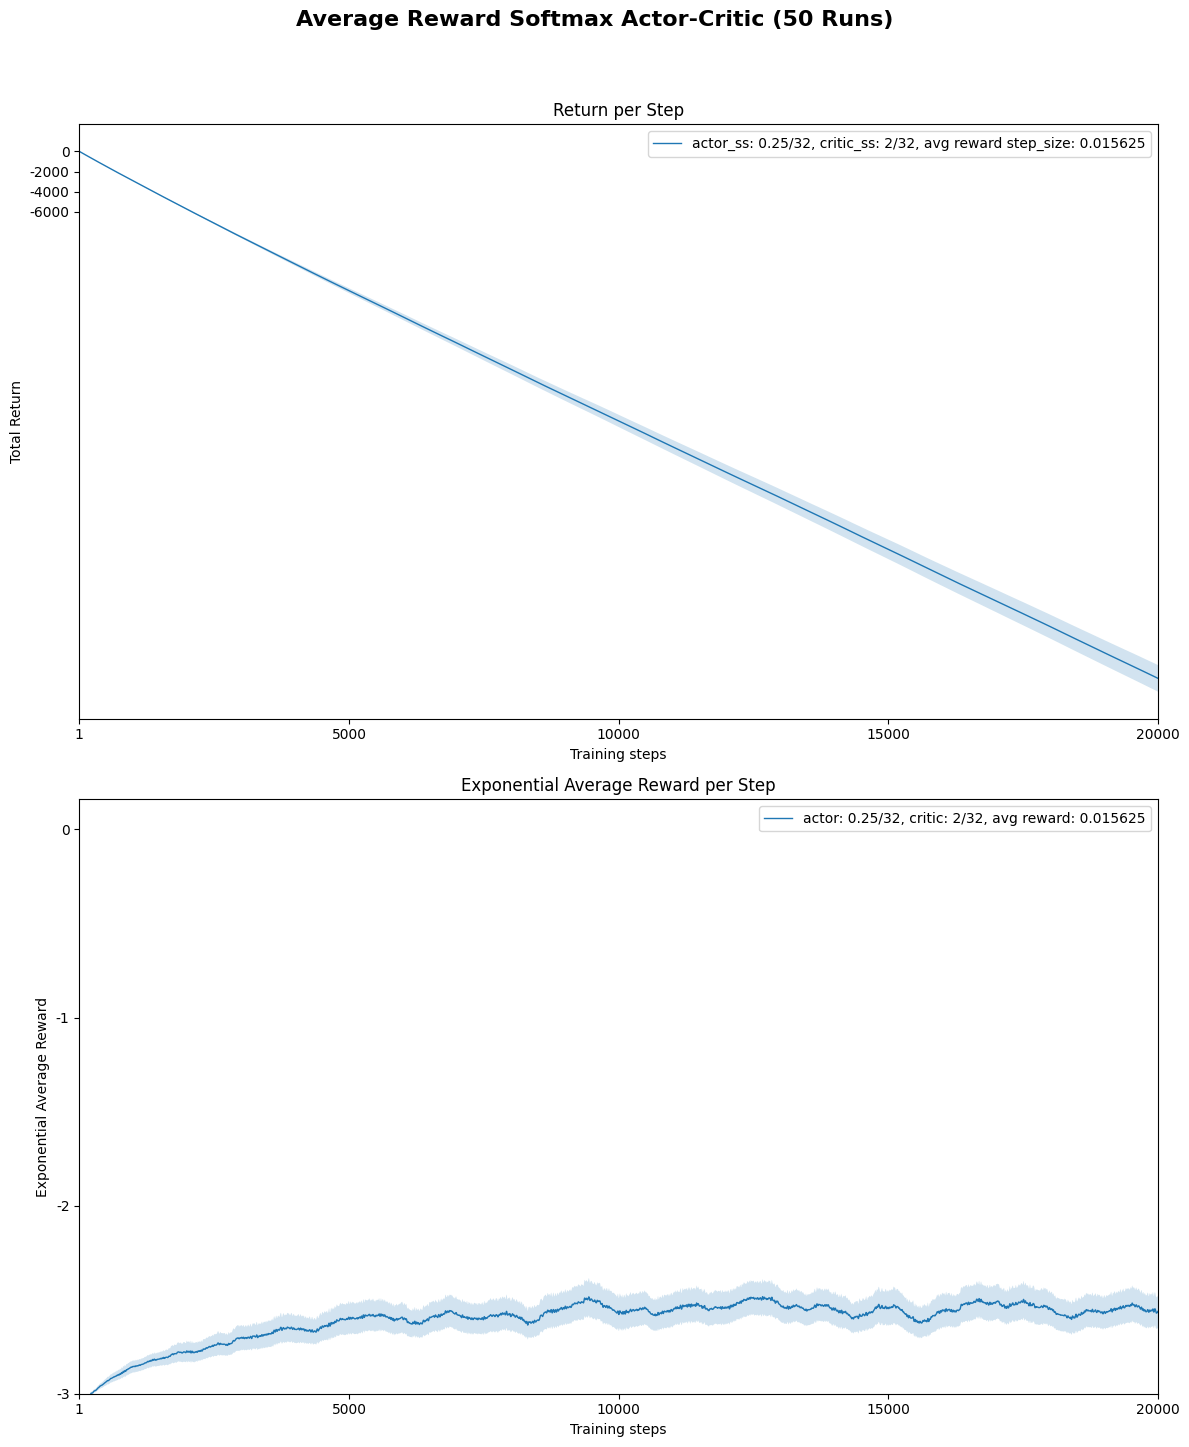

In [ ]:
experiment_parameters = {
    "max_steps" : 20000,
    "num_runs" : 50
}

# Environment parameters
environment_parameters = {}

# Agent parameters
# Each element is an array because we will be later sweeping over multiple values
# actor and critic step-sizes are divided by num. tilings inside the agent
agent_parameters = {
    "num_tilings": [32],
    "num_tiles": [8],
    "actor_step_size": [2**(-2)],
    "critic_step_size": [2**1],
    "avg_reward_step_size": [2**(-6)],
    "num_actions": 3,
    "iht_size": 4096
}

current_env = PendulumEnvironment
current_agent = ActorCriticSoftmaxAgent


run_experiment(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters)
plot_script.plot_result(agent_parameters, 'results')

In [ ]:
# my result didn't match with their result
# thier result

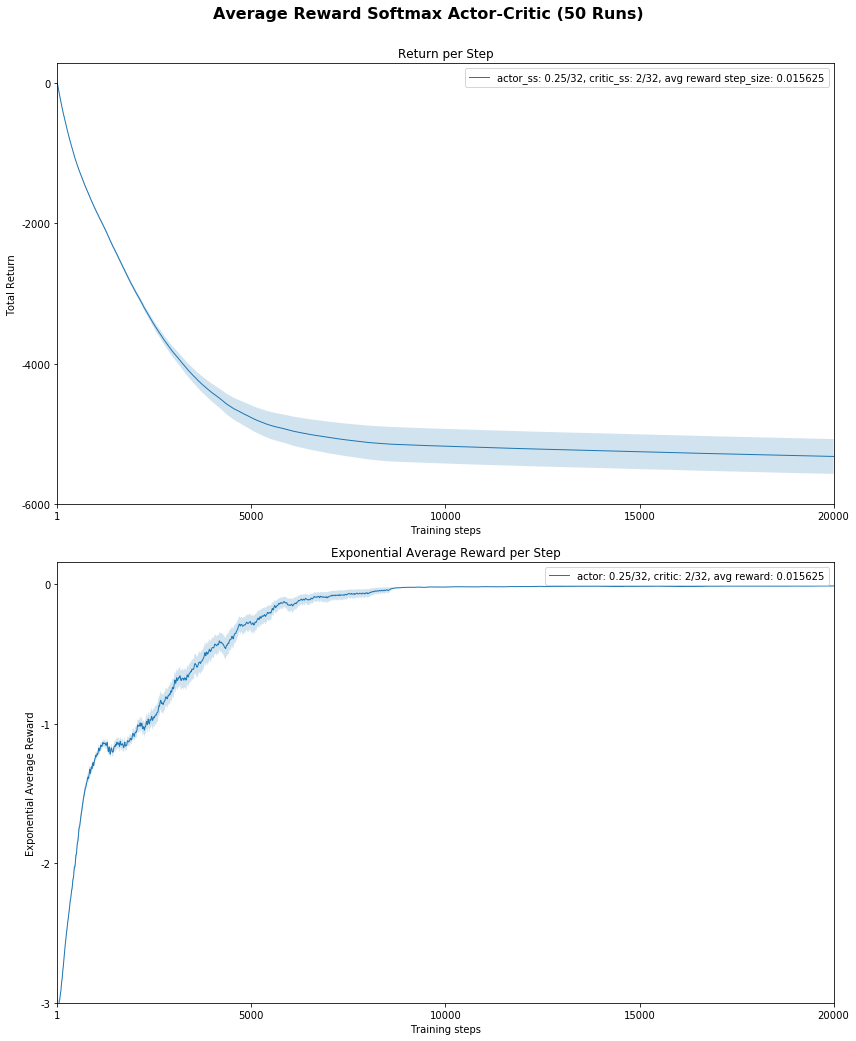

**Performance Metric**

To evaluate performance, we plotted both the return and exponentially weighted average reward over time.

In the first plot, the return is negative because the reward is negative at every state except when the pendulum is in the upright position. As the policy improves over time, the agent accumulates less negative reward, and thus the return decreases slowly. Towards the end the slope is almost flat indicating the policy has stabilized to a good policy. When using this plot however, it can be difficult to distinguish whether it has learned an optimal policy. The near-optimal policy in this Pendulum Swing-up Environment is to maintain the pendulum in the upright position indefinitely, getting near 0 reward at each time step. We would have to examine the slope of the curve but it can be hard to compare the slope of different curves.

The second plot using exponential average reward gives a better visualization. We can see that towards the end the value is near 0, indicating it is getting near 0 reward at each time step. Here, the exponentially weighted average reward shouldn't be confused with the agent’s internal estimate of the average reward. To be more specific, we used an exponentially weighted average of the actual reward without initial bias (Refer to Exercise 2.7 from the textbook (p.35) to read more about removing the initial bias). If we used sample averages instead, later rewards would have decreasing impact on the average and would not be able to represent the agent's performance with respect to its current policy effectively.

It is easier to see whether the agent has learned a good policy in the second plot than the first plot. If the learned policy is optimal, the exponential average reward would be close to 0.

Furthermore, how did we pick the best meta-parameter from the sweeps? A common method would be to pick the meta-parameter that results in the largest Area Under the Curve (AUC). However, this is not always what we want. We want to find a set of meta-parameters that learns a good final policy. When using AUC as the criteria, we may pick meta-parameters that allows the agent to learn fast but converge to a worse policy. In our case, we selected the meta-parameter setting that obtained the most exponential average reward over the last 5000 time steps.

**Parameter Sensitivity**

In addition to finding the best meta-parameters it is also equally important to plot parameter sensitivity curves to understand how our algorithm behaves.

In our simulated Pendulum problem, we can extensively test our agent with different meta-parameter configurations but it would be quite expensive to do so in real life. Parameter sensitivity curves can provide us insight into how our algorithms might behave in general. It can help us identify a good range of each meta-parameters as well as how sensitive the performance is with respect to each meta-parameter.

Here are the sensitivity curves for the three step-sizes we swept over:

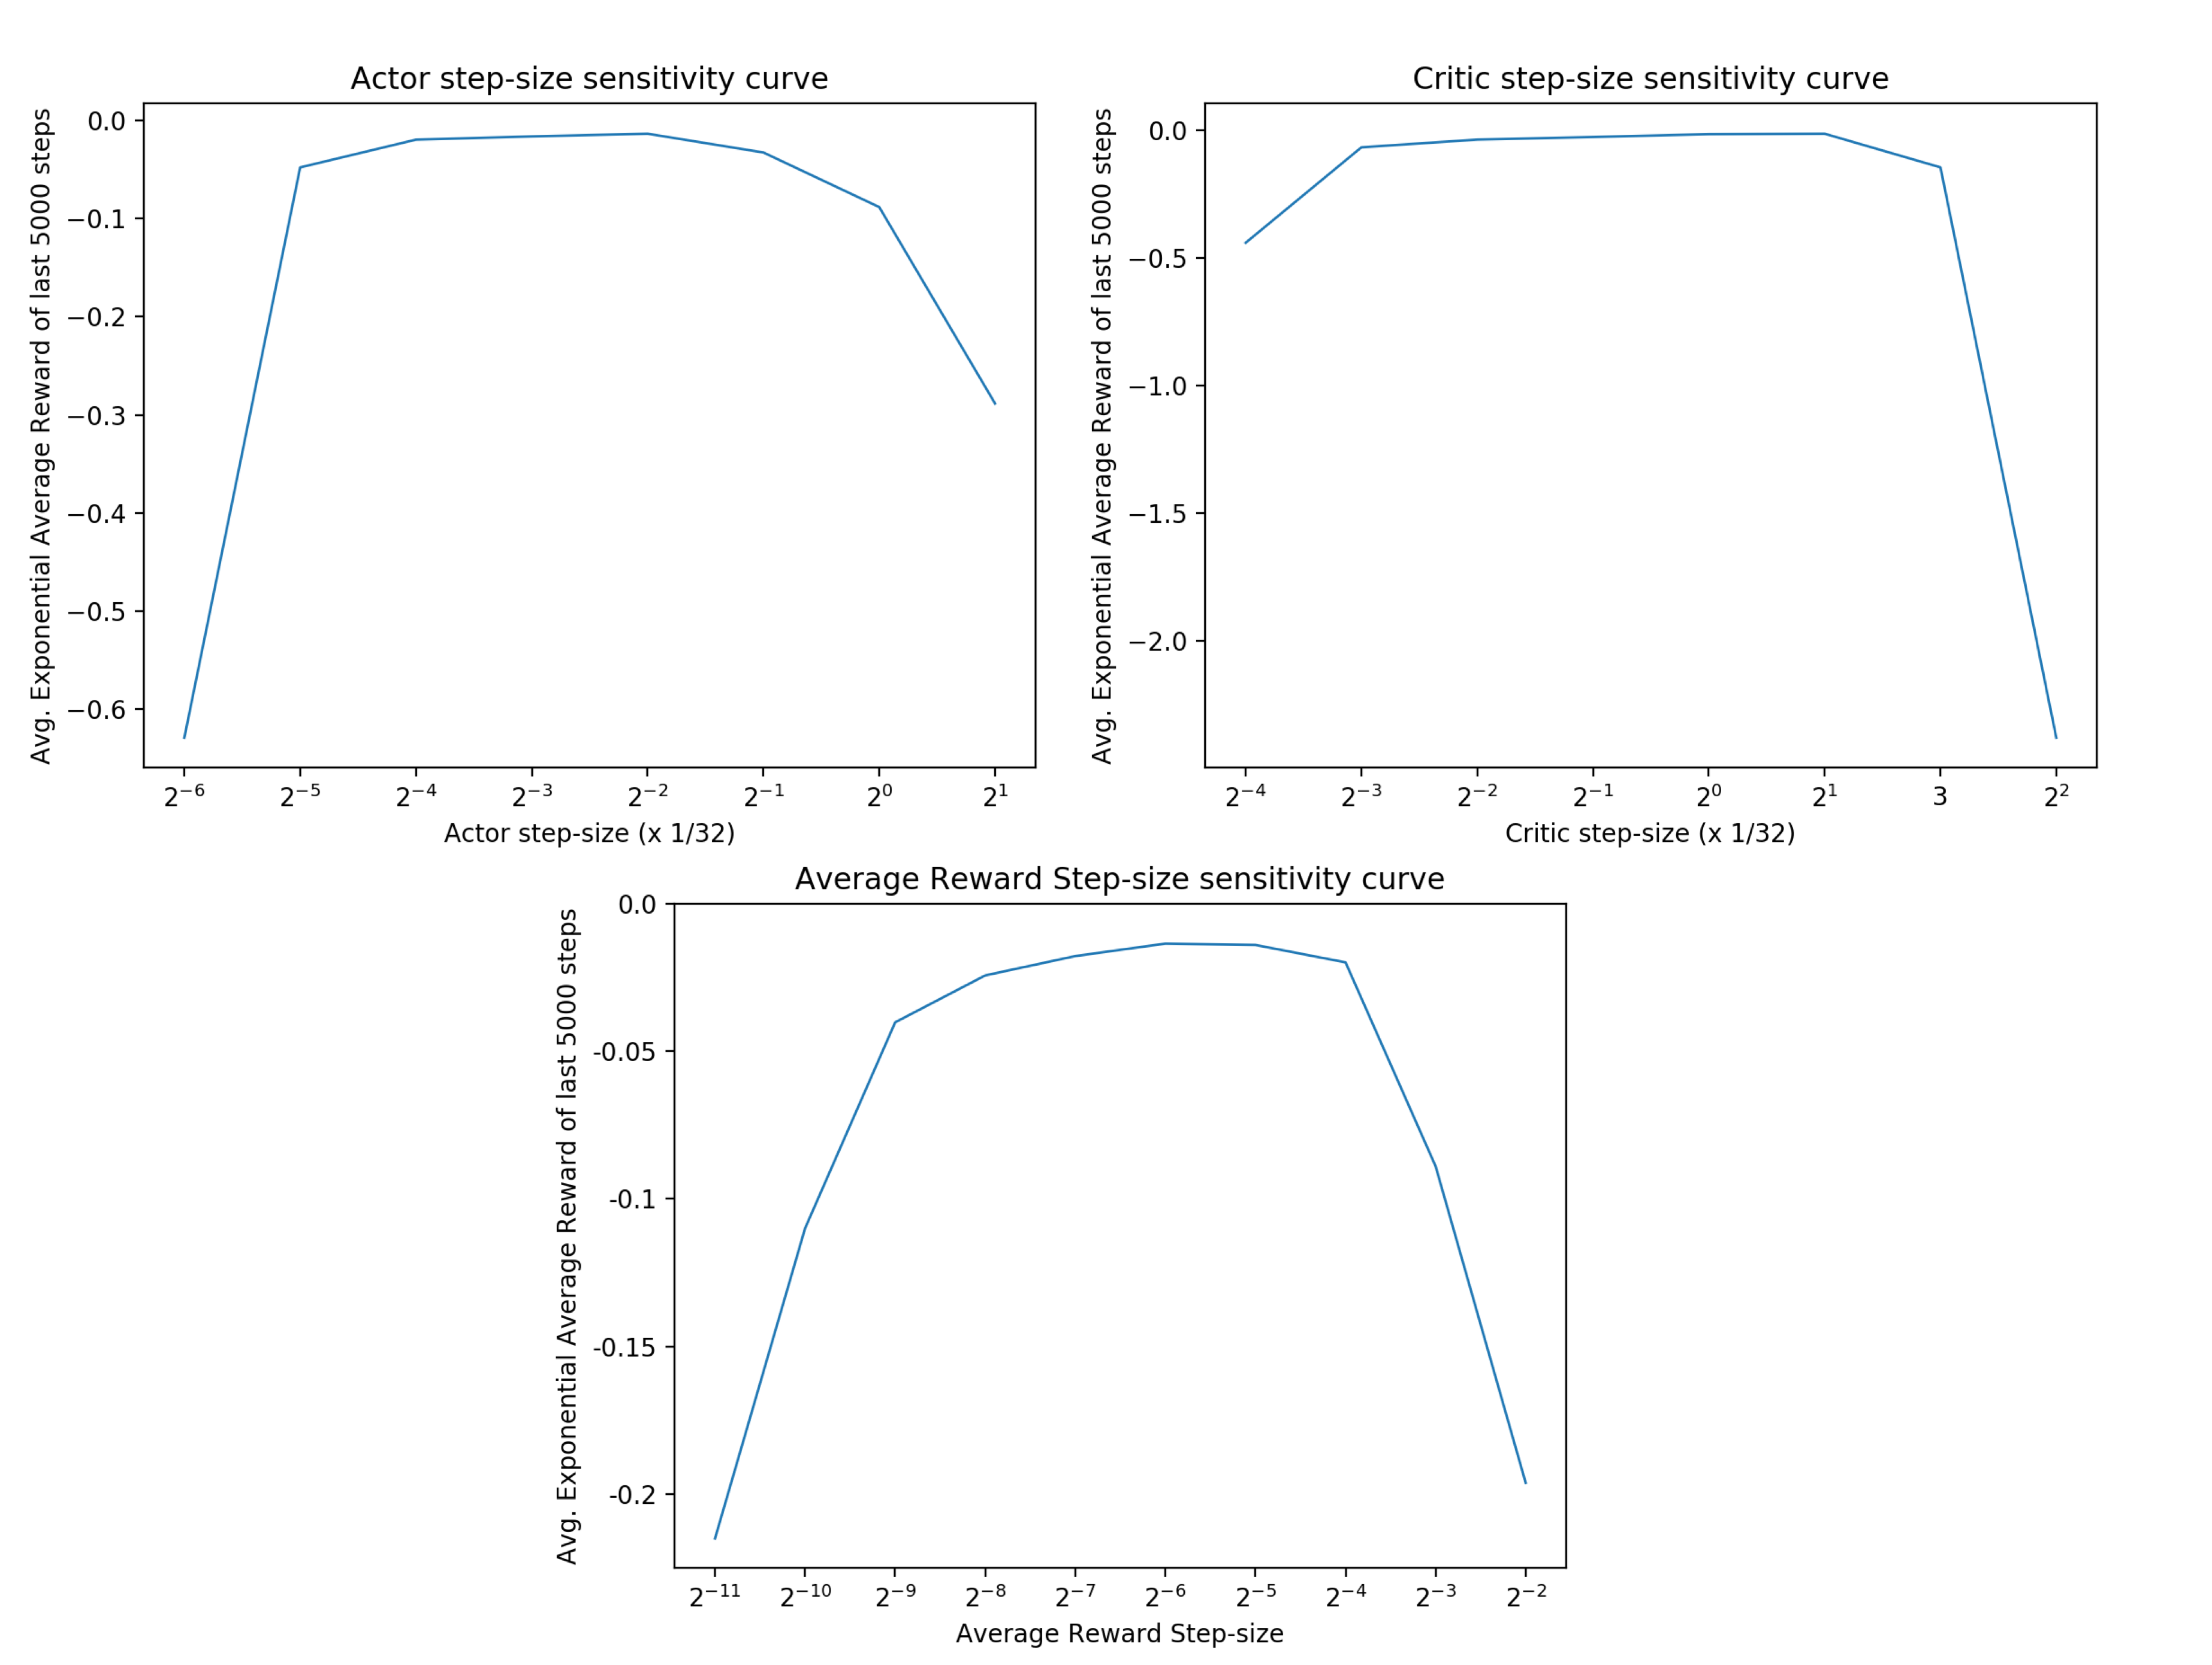

On the y-axis we use the performance measure, which is the average of the exponential average reward over the 5000 time steps, averaged over 50 different runs. On the x-axis is the meta-parameter we are testing. For the given meta-parameter, the remaining meta-parameters are chosen such that it obtains the best performance.

The curves are quite rounded, indicating the agent performs well for these wide range of values. It indicates that the agent is not too sensitive to these meta-parameters. Furthermore, looking at the y-axis values we can observe that average reward step-size is particularly less sensitive than actor step-size and critic step-size.

But how do we know that we have sufficiently covered a wide range of meta-parameters? It is important that the best value is not on the edge but in the middle of the meta-parameter sweep range in these sensitivity curves. Otherwise this may indicate that there could be better meta-parameter values that we did not sweep over